In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.tools import tool

In [3]:
from currency_converter import CurrencyConverter


In [6]:
@tool
def currency_converter(amount: float, currency: str) -> float:
    """
    Currency converter convert currency to Indian rupees INR

    Args:
        amount (float): Amount of money.
        currency (str): Corrency to be converted to INR.Eg; 'SGD', 'CAD', 'SEK', 'GBP', 'USD' etc

    Returns:
        float: Converted amount in INR.
    """
    c = CurrencyConverter()
    return c.convert(amount, currency, 'INR')

In [7]:
currency_converter.invoke({'amount' : 1, 'currency' : 'EUR'})

97.744

In [8]:
from typing import List, Dict, Any
import requests
import os

In [9]:
required = ['datetime','tempmax','tempmin','feelslike','precip','precipprob','preciptype',
            'conditions','description','humidity','windgust','cloudcover','sunrise','sunset',
            'uvindex','visibility','severerisk']

In [10]:
@tool
def weather_forecast(city: str, start_date: str, end_date: str) -> List[Dict[str, Any]]:
    """
    Gives weather forecast from start date to end date.

    Args:
        city (str): Name of the city
        start_date (str): Start date in the format YYYY-MM-DD eg; '2025-06-17'
        end_date (str): Start date in the format YYYY-MM-DD eg; '2025-06-17'

    Returns:
        List[Dict[str, Any]]: List of weather forecast for each day in dictionary format 
    """
    api_key = os.getenv('WEATHER_API')
    location = city
    start_date = start_date
    end_date = end_date
    url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{start_date}/{end_date}?key={api_key}'
    response = requests.get(url)

    filtered_info = []
    for day in response.json()['days']:
        filtered_info.append({k:v for k,v in day.items() if k in required})

    return filtered_info

In [11]:
weather_forecast.invoke({'city' : 'norway', 'start_date' : '2025-07-07', 
                           'end_date' : '2025-07-09'})

[{'datetime': '2025-07-07',
  'tempmax': 70.1,
  'tempmin': 55.7,
  'feelslike': 80.9,
  'humidity': 67.5,
  'precip': 0.236,
  'precipprob': 9.5,
  'preciptype': None,
  'windgust': 22.4,
  'cloudcover': 22.8,
  'visibility': 24.7,
  'uvindex': None,
  'sunrise': '04:08:09',
  'sunset': '22:34:56',
  'conditions': 'Partially cloudy',
  'description': ''},
 {'datetime': '2025-07-08',
  'tempmax': 70.1,
  'tempmin': 55.1,
  'feelslike': 83.0,
  'humidity': 69.1,
  'precip': 0.303,
  'precipprob': 9.5,
  'preciptype': None,
  'windgust': 21.0,
  'cloudcover': 24.1,
  'visibility': 23.7,
  'uvindex': None,
  'sunrise': '04:09:40',
  'sunset': '22:33:41',
  'conditions': 'Partially cloudy',
  'description': ''},
 {'datetime': '2025-07-09',
  'tempmax': 69.7,
  'tempmin': 55.7,
  'feelslike': 83.6,
  'humidity': 68.6,
  'precip': 0.232,
  'precipprob': 9.5,
  'preciptype': None,
  'windgust': 24.2,
  'cloudcover': 27.5,
  'visibility': 27.7,
  'uvindex': None,
  'sunrise': '04:11:14',
  'su

In [12]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0
)

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [15]:
from langchain_community.tools import DuckDuckGoSearchRun
search=DuckDuckGoSearchRun()

In [16]:
#search=TavilySearchResults()

In [17]:
tools=[currency_converter, weather_forecast, search]

In [18]:
llm_with_tools=llm.bind_tools(tools)

In [19]:
response=llm_with_tools.invoke("what will be the weather in tokiyo from jan 20  2025 to jan 25 2025")

In [20]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '68nckg80z', 'function': {'arguments': '{"city":"Tokyo","end_date":"2025-01-25","start_date":"2025-01-20"}', 'name': 'weather_forecast'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 233, 'prompt_tokens': 437, 'total_tokens': 670, 'completion_time': 0.847272727, 'prompt_time': 0.037609671, 'queue_time': 0.052622719, 'total_time': 0.884882398}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fbdbacfc-1873-4b22-a091-1134f5aa38d9-0', tool_calls=[{'name': 'weather_forecast', 'args': {'city': 'Tokyo', 'end_date': '2025-01-25', 'start_date': '2025-01-20'}, 'id': '68nckg80z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 437, 'output_tokens': 233, 'total_tokens': 670})

In [21]:
SYSTEM_PROMPT='''You are an AI travel agent and expense planner. The user wants to plan a trip to [city] from [start date] to [end date] for [number of travelers], with a budget range of [budget], and prefers [interests]. Their native currency is [currency].

Search for top attractions, restaurants, activities, and transportation options in [city].

Retrieve real-time weather and forecast for the travel dates in [city].

Find hotels in [city] within the budget, estimate total hotel cost, and suggest options.

Calculate total trip expense, including daily budget, and convert all costs to [currency].

Generate a day-by-day itinerary and a full trip summary.

Output the complete trip plan, including weather, attractions, hotel details, costs, itinerary, and summary, in a clear and organized format.'''



In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START

In [23]:
SYSTEM_PROMPT = SystemMessage(
    content=SYSTEM_PROMPT
)
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [24]:
builder=StateGraph(MessagesState)

In [25]:
builder.add_node("llm_decision_step",function_1)

In [26]:
from langgraph.prebuilt import ToolNode
builder.add_node("tools",ToolNode(tools))

In [27]:
builder.add_edge(START,"llm_decision_step")

In [28]:
from langgraph.prebuilt import tools_condition
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)


In [29]:
builder.add_edge("tools","llm_decision_step")

In [30]:
react_graph=builder.compile()

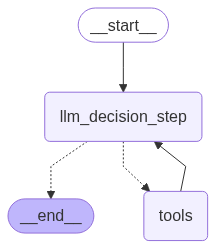

In [31]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [32]:
message=[HumanMessage(content="{city : tokyo, start_date : 16/7/2025, end_date : 23/7/2025\
                                 number of travelers is 6 currency is INR and Budjet is 200000}")]

In [33]:
#messages = [HumanMessage(content="Generate trip plan")]
messages = react_graph.invoke({"messages": message})

In [34]:
messages

{'messages': [HumanMessage(content='{city : tokyo, start_date : 16/7/2025, end_date : 23/7/2025                                 number of travelers is 6 currency is INR and Budjet is 200000}', additional_kwargs={}, response_metadata={}, id='bf080566-5d68-4945-820e-e05b2b6b78fd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kqa172w97', 'function': {'arguments': '{"query":"top attractions in Tokyo"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 538, 'prompt_tokens': 623, 'total_tokens': 1161, 'completion_time': 1.9563636359999999, 'prompt_time': 0.047359205, 'queue_time': 0.052572016, 'total_time': 2.003722841}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1ea9698f-05db-4c82-8b7b-6a340f170587-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'top attractions in Tokyo'}, 'id': 'kqa172w97', '

In [35]:
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

{city : tokyo, start_date : 16/7/2025, end_date : 23/7/2025                                 number of travelers is 6 currency is INR and Budjet is 200000}
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (kqa172w97)
 Call ID: kqa172w97
  Args:
    query: top attractions in Tokyo
================================= Tool Message =================================
Name: duckduckgo_search

This is a showcase of spectacular interactive installations and absolutely not to be missed. Digital art is trending all over Tokyo, and you'll see it worked into many other attractions around the city. The mirrored entrance to the Tokyu Plaza in Harajuku. nuu_jeed/Shutterstock 5. Join the shopping legions in Harajuku Our top recommendations for the best things to do in Tokyo, Japan, with pictures and travel tips. Find fun things to do, best places to visit, unusu

In [1]:
from agent import TravelAgent

In [2]:
agent = TravelAgent()

/home/adarsh/Travel_Agent_LangGraph/agent.py:15: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  self.tools=[custom_tool.currency_converter, custom_tool.weather_forecast, TavilySearchResults()]


In [3]:
app_graph = agent.workflow()

In [6]:
message=[HumanMessage(content="{city : tokyo, start_date : 16/7/2025, end_date : 23/7/2025\
                                 number of travelers is 6 currency is INR and Budjet is 200000}")]

In [8]:
messages = app_graph.invoke({"messages": message})

In [9]:
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

{city : tokyo, start_date : 16/7/2025, end_date : 23/7/2025                                 number of travelers is 6 currency is INR and Budjet is 200000}
================================== Ai Message ==================================
Tool Calls:
  weather_forecast (hxzb41kc3)
 Call ID: hxzb41kc3
  Args:
    city: Tokyo
    end_date: 2025-07-23
    start_date: 2025-07-16
================================= Tool Message =================================
Name: weather_forecast

[{"datetime": "2025-07-16", "tempmax": 86.1, "tempmin": 75.8, "feelslike": 95.4, "humidity": 74.0, "precip": 0.24, "precipprob": 0.0, "preciptype": null, "windgust": 32.2, "cloudcover": 31.1, "visibility": 6.8, "uvindex": null, "sunrise": "04:37:00", "sunset": "18:56:31", "conditions": "Partially cloudy", "description": ""}, {"datetime": "2025-07-17", "tempmax": 85.6, "tempmin": 75.8, "feelslike": 94.2, "humidity": 74.7, "precip": 0.1